The goal of the project is to create a functioning code that will extract information from a pH sensor, store it in a storage medium using pandas, and then plot the data into a titration curve for analysis.

Levi: My part of the project is to create a code that works on the interpretation of data from various parts of the research to create a final resulating pH. The URL to the repository is attached: 
https://github.com/nmalmberg/Genesys/blob/master/genesys.py
https://github.com/AtlasScientific/Raspberry-Pi-sample-code/blob/master/uart.py
Atlatas Scientific pH-EZO datasheet manual 

Caden: My part of the project is to take the data that was collected from the pH sensor and store it in a storage medium using pandas. This storage medium will then be used to create a titration curve for the experiment. I have used a pandas user guide to aid in the progress of my project. The URL for this information is https://pandas.pydata.org/docs/user_guide/io.html.
https://www3.ntu.edu.sg/home/ehchua/programming/howto/Regexe.html
https://docs.python.org/3/library/csv.html#csv.reader

Rylie: My part of the project is to take the collected data and plot it into a titration curve using the Matplot code. The progress I have made is the basic code for the axes with appropriate labels. The data values included are not the data points used in this experiment, but placeholders until data values are taken. The information and code was obtained from https://www.w3schools.com/python/matplotlib_labels.asp.

This code block creates a connection to the pH-EZO sensor

In [3]:
import time
import serial

#connecting to usbport
usbport = '/dev/cu.usbserial-14110'
ser = serial.Serial(usbport, 9600, timeout=0)
    
ser.write(b'C,0\n')
ser.write(b'R\n')
ser.read(7)

SerialException: [Errno 2] could not open port /dev/cu.usbserial-14110: [Errno 2] No such file or directory: '/dev/cu.usbserial-14110'

This code defines the calibration of the pH sensor

In [62]:
#Calibration values set
CALIBRATION_VALUES = [10, 7, 4]
# creating a function to create a calibration mode over the sensor #
def calibrate():
    ser.write(b'C\n')
    time.sleep(0.1)
    ser.write(b'R\n')
    time.sleep(0.1)
    ser.write(b'W'+bytes(CALIBRATION_VALUES)+b'\n')
    time.sleep(0.1)
    ser.write(b'S\n')
    time.sleep(0.1)
    ser.write(b'R\n')
    time.sleep(0.1)
    ser.close()

calibrate()

This code defines the readings of the pH sensor into a loop for collection

In [4]:
import re
import csv
def read_ph():
    ser.write(b'R\n')
    ser.write(b'C,0\n') 
    time.sleep(0.1)

    response = ser.read(7)

    response = ser.read(ser.inWaiting()).decode('utf-8').strip()
    response = re.findall(r'-?\d+\.?\d*', response)
    if response:
        pH = float(response[1])
        return pH
    else:
        return None  
    
    pH = float(response)
    return pH
    
# termination of loop #
start_time = time.time()
loop_time_limit = 60
# main loop to read pH value of the sensor # 
while True:
    pH = read_ph()
    print("pH:", pH)
    time.sleep(3)
    elapsed_time = time.time() - start_time
    if elapsed_time > loop_time_limit:
        break

pH = [pH]

with open('pH_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow('pH')
    for row in pH[1:]:
        writer.writerow(row)

NameError: name 'ser' is not defined

This code block takes data from the sensor and converts into appropriate data frame to use for analysis

In [1]:
##Read the data collected then it will convert into a dataframe then will be read to be plotted 

import pandas as pd
from io import StringIO

data = pd.read_csv('ph_data.csv', delimiter='\t', names=['Time', 'pH'])

# Convert the 'Time' column to a DateTime object
#data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%d %H:%M:%S.%f')

#Naming the acid that was used in titration
Acid = input("Enter the name of the Acid being titrated: ")

#Convert to the volume of NaOH from the time that passed
Volume = float(input("Enter the volume of NaOH added to the acid: ")) #The volume used for the titration

flow_rate = Volume / loop_time_limit #Flow Rate of the titration
NaOH = flow_rate * elapsed_time #NaOh added at specific elapsed time

##Dataframe that is stacked will columns of only the volume of NaOH and pH value of the solution
df = pd.DataFrame({ 
    'Acid': Acid,
    'NaOH': [NaOH], 
    'pH': [0]
}, index=[0])

##titration is a data frame that shows the values of the volume of NaOH and values of pH from the titration experiment
def titration(df):
    titration = pd.DataFrame(df.to_records())
    titration.name = 'titration_pH'
    titration.columns = ['Time', 'Acid', 'NaOH', 'pH']
    return titration

titration_data = titration(df)
data = data.join(titration_data, lsuffix='_left', rsuffix='_right')


/var/folders/2m/b8wn0zfs775d9yg80drd5w4w0000gn/T/ipykernel_12830/3677932525.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Enter the name of the Acid being titrated:  HCl
Enter the volume of NaOH added to the acid:  20


NameError: name 'loop_time_limit' is not defined

The code block will calulate the equivalence point of the experiment and display a graph of the titration curve.

The equivalence point is at index nan


/var/folders/2m/b8wn0zfs775d9yg80drd5w4w0000gn/T/ipykernel_1802/1994129872.py:8: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  equivalence_point = pH_change.idxmax()


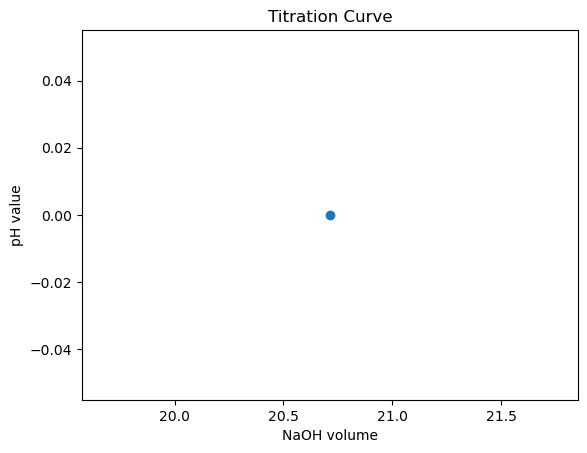

In [33]:
import numpy as np
import matplotlib.pyplot as plt

#Calculate the pH change
pH_change = titration_data['pH'].diff()

#Find the greatest change of pH
equivalence_point = pH_change[pH_change.notna()].idxmax()

#The equivalence value is printed
print("The equivalence point is at ", equivalence_point)

#Creating a scatter plot of the titration experiment
plt.scatter(titration_data['NaOH'], titration_data['pH'])

#Label varies axis and the title of the graph
plt.xlabel("NaOH volume")
plt.ylabel("pH value")
plt.title("Titration Curve")

plt.show()